In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import numpy as np
import string
import validators as val
import seaborn as sb
from yake import KeywordExtractor

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

en_model = spacy.load('en_core_web_md')

In [2]:
df = pd.read_csv('train.csv',encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


0    4342
1    3271
Name: target, dtype: int64


<AxesSubplot:xlabel='target', ylabel='count'>

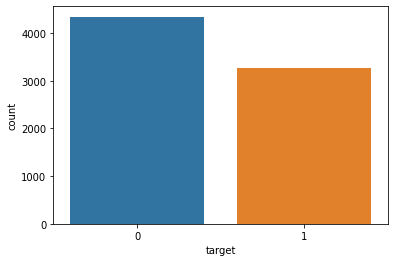

In [3]:
# check target class counts
print(df.target.value_counts())
sb.countplot(x=df.target)

The target column is well balanced

In [4]:
# check for missing data
for col in df.columns:
    if df[col].isnull().mean()>0:
        print(col,df[col].isnull().mean())

keyword 0.008012610009194798
location 0.33272034677525286


In [5]:
# drop location column and fill keyword column with the mode value
df = df[['text','target','keyword']].fillna('nill')

In [6]:
# clean keyword column
def clean_keyword(x):
    x = x.replace('%20',' ')
    tok = en_model(x)
    tok = [str(x.lemma_) for x in tok]
    return ' '.join(tok)

df.keyword = df.keyword.apply(lambda x: clean_keyword(x))

In [7]:
# text cleaning function
# removes numbers, URLs, stopwords, punctuations and twitter handles
def clean_text(text):
    toks = text.split()
    toks = [t for t in toks if not val.url(t) and '@' not in t]
    toks = ' '.join(toks)
    for p in string.punctuation:
        if p not in ('#','@'):
            toks = toks.replace(p,' ')
    
    toks = toks.lower().split()
    toks = [t for t in toks if '@' not in t]
    toks = en_model(" ".join(toks))
    toks = [t for t in toks if str(t)!="'s"]
    toks = [t for t in toks if not t.is_stop and not t.is_digit]
    toks = [str(t) for t in toks if len(str(t))>1]
    return ' '.join(toks)

In [8]:
# original vs cleaned
for _ in range(5):
    i = np.random.randint(0,len(df))
    print('Original : '+df.text[i]+'\nCleaned : '+clean_text(df.text[i]))
    print('target :',df.target[i])
    print()

Original : DK Eyewitness Travel Guide: Denmark: travel guide eBay auctions you should keep an eye on: http://t.co/qPUr3Vd7Hl
Cleaned : dk eyewitness travel guide denmark travel guide ebay auctions eye
target : 0

Original : @itss_selenaluna like a beautiful ass tragedy lol
Cleaned : like beautiful ass tragedy lol
target : 1

Original : Any lengths to rescue a cat in need! http://t.co/AMroX4Y4Nx
Cleaned : lengths rescue cat need
target : 0

Original : #Japan #Fukushima the most serious man made disaster in human history...  ÛÏa marker of radiation brain damageÛ http://t.co/Y3ZfqJsvpz
Cleaned : japan fukushima man disaster human history ûïa marker radiation brain damageû
target : 1

Original : @WhiteHouse @POTUS Just cos Germany invaded Poland Japan bombed Pearl Harbor PRE-EMPTIVE SUICIDE http://t.co/I2AAG6Lp6W
Cleaned : cos germany invaded poland japan bombed pearl harbor pre emptive suicide
target : 1



In [9]:
df['clean_text'] = df.text.apply(lambda x: clean_text(x))

<AxesSubplot:xlabel='word_count', ylabel='Count'>

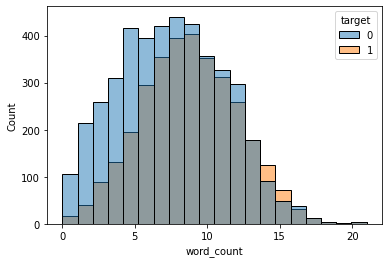

In [10]:
# get word count of each tweet after cleaning
df['word_count'] = df.clean_text.apply(lambda x: len(x.split()))

# distribution of word count
sb.histplot(data=df,x='word_count',hue='target',bins=20)

In [11]:
# 0.8% of the values in the keyword column are missing.
# impute with the extracted keywords from the cleaned text

for i in df[df.keyword=='nill'].index:
    text = df.clean_text[i]
    ex = KeywordExtractor(n=1)
    kw = ex.extract_keywords(text)
    kw = [k[0] for k in kw if k[0] in df.keyword.unique()]
    if len(kw)>0:
        df.keyword.loc[i] = kw[0]
    else:
        df.keyword.loc[i] = df.keyword.mode()[0]    

C:\Users\BJS\AppData\Local\Temp\ipykernel_18516\3101570410.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = kw[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_18516\3101570410.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = df.keyword.mode()[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_18516\3101570410.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = kw[0]
C:\Users\B

C:\Users\BJS\AppData\Local\Temp\ipykernel_18516\3101570410.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = df.keyword.mode()[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_18516\3101570410.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = kw[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_18516\3101570410.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = df.keyword.mode(

In [12]:
df[df.target==1].word_count.mean(),df[df.target==1].word_count.min(),df[df.target==1].word_count.max()

(8.857230204830326, 1, 21)

In [13]:
df[df.target==0].word_count.mean(),df[df.target==0].word_count.min(),df[df.target==0].word_count.max()

(7.66305849838784, 0, 20)

In [14]:
x = df.keyword + ' ' + df.clean_text #cleaned input text
y = df.target #target feature

# get length of longest text
maxlen = 0
for i in x:
    if len(i.split())>maxlen: maxlen=len(i.split())

# split data for training, testing and validation to (70:20:10)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=0.7)
xtest,xval,ytest,yval = train_test_split(xtest,ytest,train_size=0.7)

In [15]:
# tokenizing and padding

tk = Tokenizer()
tk.fit_on_texts(x)

seq = tk.texts_to_sequences(xtrain)
xtrain = pad_sequences(seq,maxlen=maxlen,padding='post')

seq = tk.texts_to_sequences(xval)
xval = pad_sequences(seq,maxlen=maxlen,padding='post')

seq = tk.texts_to_sequences(xtest)
xtest = pad_sequences(seq,maxlen=maxlen,padding='post')

x_voc = len(tk.word_counts)+1

xtrain.shape,xval.shape,xtest.shape,maxlen

((5329, 23), (686, 23), (1598, 23), 23)

In [16]:
# load glove vectors
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model
 
glove_embeddings = load_glove_model("D:/glove.6B.300d.txt")

Loading Glove Model
400000 words loaded!


In [17]:
# create pretrained embedding matrix
emb = np.zeros((x_voc,300))
for w,idx in tk.word_index.items():
    try: emb[idx] = glove_embeddings[w]
    except: pass

In [18]:
# linear attetion layer
class attention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = K.squeeze(e, axis=-1)   
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [19]:
# build and compile the model

def get_model(max_input_len,emb_dim,optimizer,weights):
    inputs = Input(shape=(maxlen,))
    i = Embedding(x_voc,300,weights=[emb],trainable=True)(inputs)
    i = LSTM(200,return_sequences=True)(i)
    i = attention()(i)
    i = Dense(100,activation='relu')(i)
    i = Dropout(0.1)(i)
    i = BatchNormalization()(i)
    outputs = Dense(1,activation='sigmoid')(i)

    model = Model(inputs,outputs)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model
    
adam = Adam(learning_rate=0.00001)
model = get_model(max_input_len=maxlen, 
                  emb_dim=300, 
                  weights=[emb],
                  optimizer=adam)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 embedding (Embedding)       (None, 23, 300)           4332600   
                                                                 
 lstm (LSTM)                 (None, 23, 200)           400800    
                                                                 
 attention (attention)       (None, 200)               223       
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 batch_normalization (BatchN  (None, 100)              400   

In [20]:
# training at 40 epochs and saving weights with smallest val_loss

def train(xtrain,ytrain,xval,yval,epochs,batch_size,verbose=1,class_weight=None,filename='model.h5'):
    if verbose > 0:
        print(f'Epoch = 1/{epochs}')
    metrics = {'accuracy':[],'val_accuracy':[],'loss':[],'val_loss':[]}
    model.fit(xtrain,ytrain,epochs=1,batch_size=batch_size,verbose=verbose,class_weight=class_weight)
    loss,acc = model.evaluate(xtrain,ytrain,verbose=0)
    metrics['accuracy'].append(acc)
    metrics['loss'].append(loss)
    loss,acc = model.evaluate(xval,yval,verbose=verbose)
    metrics['val_loss'].append(loss)
    metrics['val_accuracy'].append(acc)
    tf.keras.models.save_model(model,'model.h5')

    for i in range(2,epochs+1):
        if verbose > 0:
            print(f'Epoch = {i}/{epochs}')
        model.fit(xtrain,ytrain,epochs=1,batch_size=batch_size,verbose=verbose,class_weight=class_weight)
        loss,acc = model.evaluate(xtrain,ytrain,verbose=0)
        metrics['accuracy'].append(acc)
        metrics['loss'].append(loss)
        loss,acc = model.evaluate(xval,yval,verbose=verbose)
        metrics['val_loss'].append(loss)
        metrics['val_accuracy'].append(acc)
        if loss<min(metrics['val_loss'][:-1]): 
            tf.keras.models.save_model(model,filename)
        
    return metrics
        
metrics = train(xtrain,ytrain,xval,yval,verbose=1,batch_size=32,epochs=30)
        
     

Epoch = 1/30
22/22 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.7041
Epoch = 2/30
22/22 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.7595
Epoch = 3/30
22/22 [==============================] - 0s 3ms/step - loss: 0.5322 - accuracy: 0.7828
Epoch = 4/30
22/22 [==============================] - 0s 3ms/step - loss: 0.4747 - accuracy: 0.7901
Epoch = 5/30
22/22 [==============================] - 0s 3ms/step - loss: 0.4534 - accuracy: 0.7930
Epoch = 6/30
22/22 [==============================] - 0s 3ms/step - loss: 0.4432 - accuracy: 0.7974
Epoch = 7/30
22/22 [==============================] - 0s 3ms/step - loss: 0.4371 - accuracy: 0.8047
Epoch = 8/30
22/22 [==============================] - 0s 3ms/step - loss: 0.4320 - accuracy: 0.8061
Epoch = 9/30
22/22 [==============================] - 0s 4ms/step - loss: 0.4266 - accuracy: 0.8032
Epoch = 10/30
22/22 [==============================] - 0s 3ms/step - loss: 0.4232 - accuracy: 0.8090

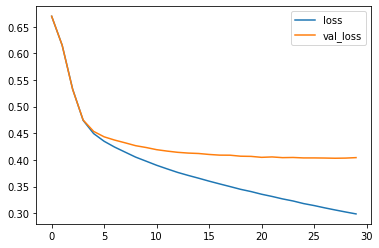

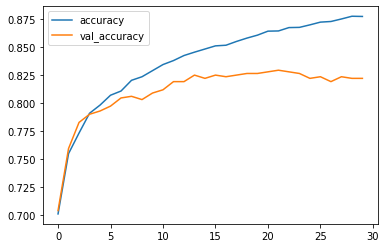

In [21]:
# visualising training and validation metrics
metrics = pd.DataFrame(metrics)
metrics[['loss','val_loss']].plot()
plt.show()
metrics[['accuracy','val_accuracy']].plot()
plt.show()

In [22]:
# load model and evaluate
model = tf.keras.models.load_model('model.h5',custom_objects={'attention':attention})
model.evaluate(xval,yval) #validation data
model.evaluate(xtest,ytest) #training data
model.evaluate(xtrain,ytrain) #testing data

167/167 [==============================] - 1s 4ms/step - loss: 0.3060 - accuracy: 0.8752


[0.3060190677642822, 0.8752111196517944]

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       386
           1       0.83      0.75      0.79       300

    accuracy                           0.82       686
   macro avg       0.82      0.82      0.82       686
weighted avg       0.82      0.82      0.82       686



<AxesSubplot:>

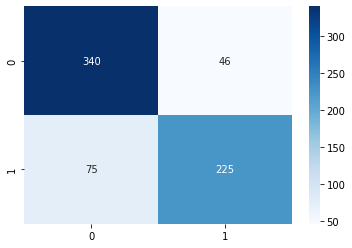

In [23]:
# classification report and confusion matrix for validation data
pred = np.round(model.predict(xval)).flatten()
print(classification_report(yval,pred))
sb.heatmap(confusion_matrix(yval,pred),annot=True,cmap='Blues',fmt='d')

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       902
           1       0.82      0.72      0.77       696

    accuracy                           0.81      1598
   macro avg       0.81      0.80      0.80      1598
weighted avg       0.81      0.81      0.81      1598



<AxesSubplot:>

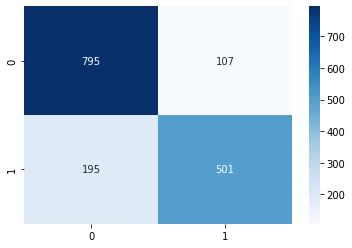

In [24]:
# classification report and confusion matrix for test data
pred = np.round(model.predict(xtest)).flatten()
print(classification_report(ytest,pred))
sb.heatmap(confusion_matrix(ytest,pred),annot=True,cmap='Blues',fmt='d')



training 1/5

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       868
           1       0.75      0.66      0.70       655

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



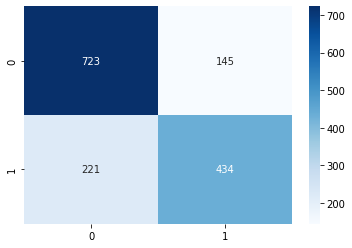


################################################

training 2/5

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       869
           1       0.67      0.65      0.66       654

    accuracy                           0.71      1523
   macro avg       0.71      0.71      0.71      1523
weighted avg       0.71      0.71      0.71      1523



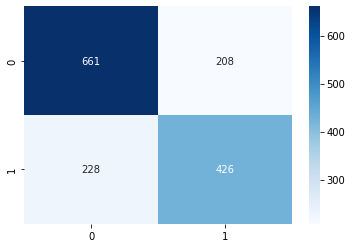


################################################

training 3/5

              precision    recall  f1-score   support

           0       0.79      0.72      0.76       869
           1       0.67      0.75      0.71       654

    accuracy                           0.73      1523
   macro avg       0.73      0.74      0.73      1523
weighted avg       0.74      0.73      0.74      1523



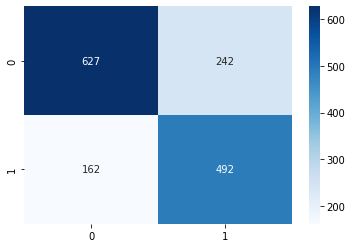


################################################

training 4/5

              precision    recall  f1-score   support

           0       0.72      0.82      0.76       868
           1       0.70      0.57      0.63       654

    accuracy                           0.71      1522
   macro avg       0.71      0.69      0.70      1522
weighted avg       0.71      0.71      0.71      1522



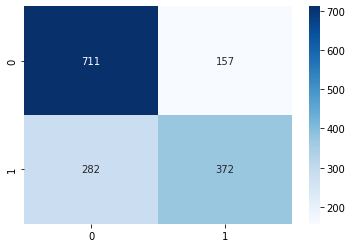


################################################

training 5/5

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       868
           1       0.78      0.77      0.78       654

    accuracy                           0.81      1522
   macro avg       0.81      0.80      0.81      1522
weighted avg       0.81      0.81      0.81      1522



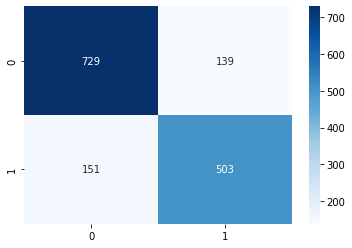


################################################

avg f1-score : 0.6957944172673937
avg accuracy : 0.7458333584986406


In [27]:
# check performance with kfold

n = 5
acc = 0
f1 = 0
sfk = StratifiedKFold(n_splits=n)
sfk.get_n_splits(x,y)
count=1
for train_idx,test_idx in sfk.split(x,y):
    xtrain,xtest = x[train_idx],x[test_idx]
    ytrain,ytest = y[train_idx],y[test_idx]
    
    tk = Tokenizer()
    tk.fit_on_texts(x)

    seq = tk.texts_to_sequences(xtrain)
    xtrain = pad_sequences(seq,maxlen=maxlen,padding='post')

    seq = tk.texts_to_sequences(xtest)
    xtest = pad_sequences(seq,maxlen=maxlen,padding='post')

    x_voc = len(tk.word_counts)+1
    
    emb = np.zeros((x_voc,300))
    for w,idx in tk.word_index.items():
        try: emb[idx] = glove_embeddings[w]
        except: pass
        
    adam = Adam(learning_rate=0.00001)
    model = get_model(maxlen,300,adam,[emb])
    print(f'training {count}/{n}')
    model_filename = 'kfold_model.h5'
    train(xtrain,ytrain,xtest,ytest,epochs=30,batch_size=32,verbose=0,filename=model_filename)
    model = tf.keras.models.load_model(model_filename,custom_objects={'attention':attention})
    pred = np.round(model.predict(xtest)).flatten()
    print()
    f1 += f1_score(ytest,pred)
    acc += accuracy_score(ytest,pred)
    
    print(classification_report(ytest,pred))
    sb.heatmap(confusion_matrix(ytest,pred),annot=True,cmap='Blues',fmt='d')
    plt.show()
    print("\n################################################\n")
    
    count+=1
    
print('avg f1-score :',f1/n)
print('avg accuracy :',acc/n)

In [26]:
# submission

test = pd.read_csv('test.csv',encoding='utf-8')
test.keyword = test.keyword.fillna(test.keyword.mode()[0])
test.keyword = test.keyword.apply(lambda x: clean_keyword(x))
test = test[['id','text','keyword']].fillna('nill')

for i in test[test.keyword=='nill'].index:
    text = test.clean_text[i]
    ex = KeywordExtractor(n=1)
    kw = ex.extract_keywords(text)
    kw = [k[0] for k in kw if k[0] in test.keyword.unique()]
    if len(kw)>0:
        test.keyword.loc[i] = kw[0]
    else:
        test.keyword.loc[i] = test.keyword.mode()[0] 

test.text = test.keyword + ' '+ test.text

x_sub = test.text.apply(lambda x: clean_text(x))

seq = tk.texts_to_sequences(x_sub)
x_sub = pad_sequences(seq,maxlen=maxlen,padding='post')

pred = np.round(model.predict(x_sub)).flatten()

test['target'] = pred
test.target = test.target.apply(lambda x: int(x))

test[['id','target']].to_csv('D:/submission.csv',index=False)